#                                    News Classification Project

# 1.) Data Exploration & Manipulation

In [1]:
#Loading all the required libraries
import os                                                                    
import pandas as pd
import numpy as np                     
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import nltk
import re
import string
from collections import defaultdict
from warnings import simplefilter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.externals import joblib

In [2]:
# Set the working directory
os.chdir("C:/Users/Navaneeth/Desktop/Assignment_Data Science")
#load the given csv and xlsx datafiles
d1= pd.read_excel("news_details.xlsx")
print("The shape of news_details dataset is :",d1.shape)
d2= pd.read_excel("category_mapping.xlsx")
print("The shape of category_mapping dataset is :",d2.shape)
d3=pd.read_csv("categories.csv")
print("The shape of categories dataset is :",d3.shape)

The shape of news_details dataset is : (3544, 4)
The shape of category_mapping dataset is : (3544, 2)
The shape of categories dataset is : (7, 2)


In [3]:
#Visualize first 5 rows of d1
d1.head()

,news_id,snippet,title,news_description
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...
2,5cb429984f646938b110f937_google,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...
3,5cb426b34f646938b10bbeca_google,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...
4,5cb426f74f646938b10c3857_google,KFH has partnered with IDEMIA to launch Kuwait...,KFH partners with IDEMIA's to launch metal pay...,NaN


In [4]:
#Visualize first 5 rows of d2
d2.head()

,news_id,category_id
0,5cb377684f646938b14a96f1_google,4
1,5cb426d44f646938b10bf6b6_google,4
2,5cb429984f646938b110f937_google,2
3,5cb426b34f646938b10bbeca_google,5
4,5cb426f74f646938b10c3857_google,7


In [5]:
#Visualize first 5 rows of d3
d3.head()

,id,category
0,1,Layoff
1,2,Mergers and Acquisitions
2,3,Mass Hiring
3,4,Executive Movement
4,5,Centre Setup and Expansion


In [6]:
#renaming column 'id' of d3 to category_id to join it with d2
d3.rename(columns={'id':'category_id'},inplace=True)
mapped_data=d2.merge(d3,on='category_id',how='left')
print("The shape of mapped_data dataset is :",mapped_data.shape)
mapped_data.head()


The shape of mapped_data dataset is : (3544, 3)


,news_id,category_id,category
0,5cb377684f646938b14a96f1_google,4,Executive Movement
1,5cb426d44f646938b10bf6b6_google,4,Executive Movement
2,5cb429984f646938b110f937_google,2,Mergers and Acquisitions
3,5cb426b34f646938b10bbeca_google,5,Centre Setup and Expansion
4,5cb426f74f646938b10c3857_google,7,Partnerships


In [7]:
# Join d1 and mapped_data on 'news_id', drop the duplicate rows & reset index
final_data=d1.merge(mapped_data,on='news_id',how='left')
final_data.drop_duplicates(keep='first',inplace=True)
final_data.reset_index(drop=True,inplace=True)
print("The shape of final_data dataset is :",final_data.shape)
final_data.head()

The shape of final_data dataset is : (2721, 6)


,news_id,snippet,title,news_description,category_id,category
0,5cb377684f646938b14a96f1_google,"New Delhi: Bank of Baroda, which has become th...",Bank of Baroda to hire consultancy firm to eva...,NaN,4,Executive Movement
1,5cb426d44f646938b10bf6b6_google,He said his plans would be discussed with the ...,Foxconn chairman Gou says he aims to step down...,TAIPEI (Reuters) - The chairman of Taiwan's Fo...,4,Executive Movement
2,5cb429984f646938b110f937_google,ZF Friedrichshafen AG has announced that it ha...,ZF Finalizes USD 7 Billion Deal to Acquire WABCO,Share 0 Share 0\n\nZF Friedrichshafen AG has a...,2,Mergers and Acquisitions
3,5cb426b34f646938b10bbeca_google,Zhejiang Geely Holding (ZGH) has begun constru...,Geely Begins Work On New Lotus Plant In China,Zhejiang Geely Holding (ZGH) has begun constru...,5,Centre Setup and Expansion
4,5cb426f74f646938b10c3857_google,KFH has partnered with IDEMIA to launch Kuwait...,KFH partners with IDEMIA's to launch metal pay...,NaN,7,Partnerships


# 2.) Missing Value Analysis & Imputation

In [8]:
# Check the missing values in the final_data
print(final_data.isnull().sum())
# Imputing NaN values of news_description with title
final_data['news_description']= np.where((final_data['news_description'].isnull()),final_data['title'],final_data['news_description'])
final_data['snippet']=np.where((final_data['snippet'].isnull()),final_data['title'],final_data['snippet'])
#drop the irrelevant columns
final_data.drop(['news_id','category_id','snippet','title'],axis=1,inplace=True)
print("The shape of final data is :",final_data.shape)
final_data.head()

news_id               0
snippet               5
title                 0
news_description    186
category_id           0
category              0
dtype: int64
The shape of final data is : (2721, 2)


,news_description,category
0,Bank of Baroda to hire consultancy firm to eva...,Executive Movement
1,TAIPEI (Reuters) - The chairman of Taiwan's Fo...,Executive Movement
2,Share 0 Share 0\n\nZF Friedrichshafen AG has a...,Mergers and Acquisitions
3,Zhejiang Geely Holding (ZGH) has begun constru...,Centre Setup and Expansion
4,KFH partners with IDEMIA's to launch metal pay...,Partnerships


In [9]:
#Recheck the missing values
final_data.isnull().sum()

news_description    0
category            0
dtype: int64

# 3.) Data Pre-Processing & Lemmatization

In [10]:
#set & initialize the stopwords & punctuation data
stop = set(stopwords.words("english"))
punc = set(string.punctuation)

#Function to remove stopwords,punctuations,numeric digits & free spaces 
corpus=[]
def clean(doc):
    result = re.sub(r'^\s+', "",doc)                                             #Removing spaces from start and end
    stop_free = ' '.join([i for i in result.lower().split() if i not in stop])   #case folding & stop words removal
    punc_free = ''.join([i for i in stop_free if i not in punc])                 # punctuations removal
    num_free = ''.join([i for i in punc_free if not i.isdigit()])                # numbers removal
    review = re.sub(r'\s+', ' ',num_free)                                        # Convert multiple spaces to single space
    corpus.append(review)

In [11]:
#call the clean function to pre-process the data of all the rows of news_description column
for i in range(0, final_data.shape[0]) :
    clean(final_data.iloc[i,0])
    
print("The length of the corpus is :",len(corpus))

The length of the corpus is : 2721


In [12]:
# Lemmatization
lemmatizer= WordNetLemmatizer()
# function to lemmatize the words in the corpus
for i in range(0,len(corpus)):
    words= nltk.word_tokenize(corpus[i])
    newwords=[lemmatizer.lemmatize(word) for word in words]
    corpus[i]= " ".join(newwords)
    
print("The length of the corpus is :",len(corpus))

The length of the corpus is : 2721


In [13]:
#Convert the post corpus to dataframe
data= pd.DataFrame(corpus,columns={'news_description'})
#Concat the catogories of final_data with data
whole_data=pd.concat([data,final_data['category']],axis=1)
# Transform the string values of category to respective label encoded numeric values
encoder = LabelEncoder()
whole_data['category']=encoder.fit_transform(whole_data['category'])

In [14]:
#Visualize the first 5 rows of whole_data
whole_data.head()

,news_description,category
0,bank baroda hire consultancy firm evaluate boa...,2
1,taipei reuters chairman taiwan foxconn assembl...,2
2,share share nnzf friedrichshafen ag announced ...,5
3,zhejiang geely holding zgh begun construction ...,0
4,kfh partner idemias launch metal payment card,6


# 4.) Visualization of text Data

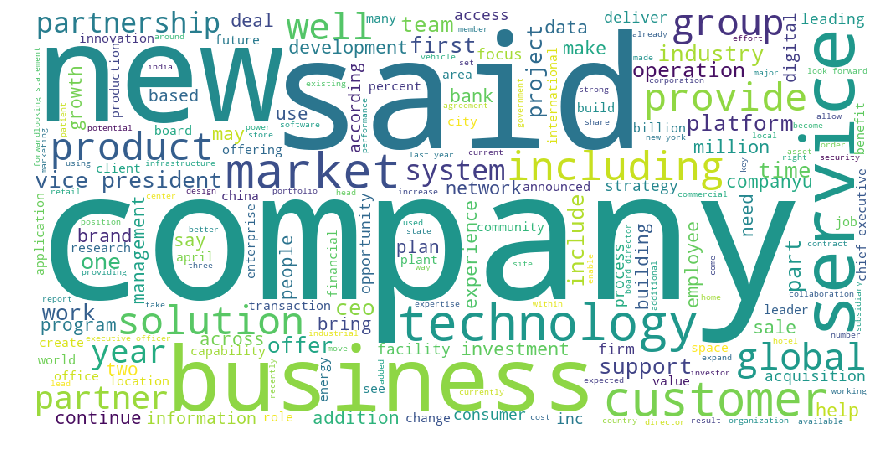

<Figure size 432x288 with 0 Axes>

In [12]:
# Visualize the text data with wordcloud
wordcloud = WordCloud(width = 1000, height = 500, stopwords = STOPWORDS, background_color = 'white').generate(''.join(whole_data['news_description']))
plt.figure(figsize = (15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
plt.savefig("word_cloud.png", format="png")

# 5.) Feature Extraction using TF-IDF Vectorization

In [15]:
#Intiatise TD-IDF Vectorizer and transform the input text data
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(whole_data['news_description']).toarray()
labels = whole_data['category']
print("The shape of features is :",features.shape)

The shape of features is : (2721, 16999)


In [16]:
# To see the top 10 features by ngram 
features_by_gram = defaultdict(list)
for f, w in zip(tfidf.get_feature_names(), tfidf.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))
top_n = 10
for gram, features in features_by_gram.items():
    top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    print('{}-gram top:'.format(gram), top_features)

1-gram top: ['aa', 'aaron', 'abbus', 'abbvie', 'abovennvisit', 'absent', 'absorbing', 'absorption', 'abuse', 'academia']
2-gram top: ['ability bring', 'ability company', 'ability expand', 'ability generate', 'ability integrate', 'ability make', 'ability provide', 'able build', 'able choose', 'able obtain']


# 6.) Train-Test Split

In [19]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.2,random_state=1)

# 7.) Data Modelling

# * Random Forest Model with 4 fold Cross validation

In [26]:
# Import the random forest model
rf=RandomForestClassifier(random_state=1)
# Define the list of estimators for the Random forest to be built
est=list([100,150,200,300,500,700])
param_grid= dict(n_estimators=est)
print(param_grid)
# instantiate the gridsearch using random forest model
grid_rf = GridSearchCV(rf, param_grid, cv=4,scoring='accuracy', return_train_score=False)
# Fit the random forest grid
grid_rf.fit(X_train,y_train)
#Print the best estimated model
print("The best cross validated estimator of Random Forest is :",grid_rf.best_estimator_)
# Print the best score of accuracy
print("The best cross validated Accuracy of Random Forest is :",grid_rf.best_score_)
#Print the given parameters & corresponding accuracy value from each 4-fold cross validation 
pd.DataFrame(grid_rf.cv_results_)[[ 'params','mean_test_score']]

{'n_estimators': [100, 150, 200, 300, 500, 700]}
The best cross validated estimator of Random Forest is : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
The best cross validated Accuracy of Random Forest is : 0.7486213235294118


,params,mean_test_score
0,{'n_estimators': 100},0.743107
1,{'n_estimators': 150},0.745864
2,{'n_estimators': 200},0.748621
3,{'n_estimators': 300},0.747243
4,{'n_estimators': 500},0.745404
5,{'n_estimators': 700},0.743566


In [27]:
# Predict on the test dataset
rf_predicted=grid_rf.predict(X_test)

In [21]:
# Function for confusion matrix heatmap
def heatmapcm(actual,predicted,mname) :
    cm = confusion_matrix(actual, predicted)
    df_cm = pd.DataFrame(cm, range(7),range(7)) 
    fig, ax = plt.subplots(figsize=(6,6))
    sns.heatmap(df_cm, annot=True,fmt='g')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    ax.set_title(f'Confusion Matrix for {mname} Model')
    return plt.show()

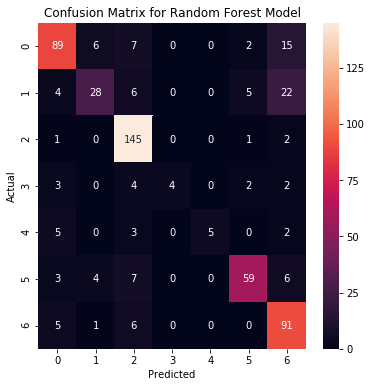

                            precision    recall  f1-score   support

Centre Setup and Expansion       0.81      0.75      0.78       119
                     Deals       0.72      0.43      0.54        65
        Executive Movement       0.81      0.97      0.89       149
                    Layoff       1.00      0.27      0.42        15
               Mass Hiring       1.00      0.33      0.50        15
  Mergers and Acquisitions       0.86      0.75      0.80        79
              Partnerships       0.65      0.88      0.75       103

                 micro avg       0.77      0.77      0.77       545
                 macro avg       0.84      0.63      0.67       545
              weighted avg       0.79      0.77      0.76       545

The test accuracy of Random Forest is :77.248%


In [31]:
# call the heatmap function for random forest
heatmapcm(y_test,rf_predicted,'Random Forest')
# print the classification metrics report
print(metrics.classification_report(y_test, rf_predicted,target_names=encoder.classes_))
# print the accuracy score for test dataset
print(f'The test accuracy of Random Forest is :{(accuracy_score(y_test, rf_predicted)*100):.3f}%')

# * Multinomial NaiveBayes model with 4 fold Cross validation

In [20]:
# Import the Multinomial NB model
nb = MultinomialNB()
# Define the list of estimators for the Multinomial NB model to be built
est=list([0.01,0.1,0.2,0.5,1,2,3,4])
param_grid= dict(alpha=est)
print(param_grid)
# instantiate the gridsearch using Multinomial NB model
grid_nb = GridSearchCV(nb, param_grid, cv=4,scoring='accuracy', return_train_score=False)
# Fit the Multinomial NB model
grid_nb.fit(X_train,y_train)
#Print the best estimated model
print("The best cross validated estimator of Multinomial NB model is :",grid_nb.best_estimator_)
# Print the best score of accuracy
print("The best cross validated Accuracy of Multinomial NB model is :",grid_nb.best_score_)
#Print the given parameters & corresponding accuracy value from each 4-fold cross validation 
pd.DataFrame(grid_nb.cv_results_)[[ 'params','mean_test_score']]

{'alpha': [0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4]}
The best cross validated estimator of Multinomial NB model is : MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
The best cross validated Accuracy of Multinomial NB model is : 0.7320772058823529


,params,mean_test_score
0,{'alpha': 0.01},0.730699
1,{'alpha': 0.1},0.732077
2,{'alpha': 0.2},0.715074
3,{'alpha': 0.5},0.672794
4,{'alpha': 1},0.622702
5,{'alpha': 2},0.559283
6,{'alpha': 3},0.533548
7,{'alpha': 4},0.509191


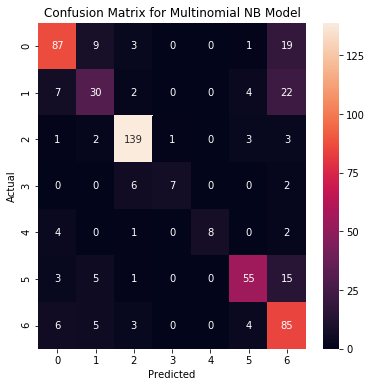

                            precision    recall  f1-score   support

Centre Setup and Expansion       0.81      0.73      0.77       119
                     Deals       0.59      0.46      0.52        65
        Executive Movement       0.90      0.93      0.91       149
                    Layoff       0.88      0.47      0.61        15
               Mass Hiring       1.00      0.53      0.70        15
  Mergers and Acquisitions       0.82      0.70      0.75        79
              Partnerships       0.57      0.83      0.68       103

                 micro avg       0.75      0.75      0.75       545
                 macro avg       0.79      0.66      0.70       545
              weighted avg       0.77      0.75      0.75       545

The test accuracy of Multinomial Naive Bayes model is :75.413%


In [22]:
# Predict on the test dataset
nb_predicted=grid_nb.predict(X_test)
# call the heatmap function for NB model
heatmapcm(y_test,nb_predicted,'Multinomial NB')
# print the classification metrics report
print(metrics.classification_report(y_test, nb_predicted,target_names=encoder.classes_))
# print the accuracy score for test dataset
print(f'The test accuracy of Multinomial Naive Bayes model is :{(accuracy_score(y_test,nb_predicted)*100):.3f}%')

# * Logistic Regression model with 4 fold Cross validation

In [39]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# Import the Logistic Regression model
lr= LogisticRegression(random_state=0)
# Define the list of estimators for Logistic Regression model to be built
est=list([1,5,10,15,20,25,30])
param_grid= dict(C=est)
print(param_grid)
grid_lr = GridSearchCV(lr, param_grid, cv=4,scoring='accuracy', return_train_score=False)
# Fit the random forest grid
grid_lr.fit(X_train,y_train)
#Print the best estimated model
print("The best cross validated estimator of Logistic Regression model is :",grid_lr.best_estimator_)
# Print the best score of accuracy
print("The best cross validated Accuracy of Logistic Regression model is :",grid_lr.best_score_)
#Print the given parameters & corresponding accuracy value from each 4-fold cross validation 
pd.DataFrame(grid_lr.cv_results_)[[ 'params','mean_test_score']]

{'C': [1, 5, 10, 15, 20, 25, 30]}
The best cross validated estimator of Logistic Regression model is : LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
The best cross validated Accuracy of Logistic Regression model is : 0.8092830882352942


,params,mean_test_score
0,{'C': 1},0.748162
1,{'C': 5},0.794118
2,{'C': 10},0.802390
3,{'C': 15},0.805607
4,{'C': 20},0.805147
5,{'C': 25},0.806985
6,{'C': 30},0.809283


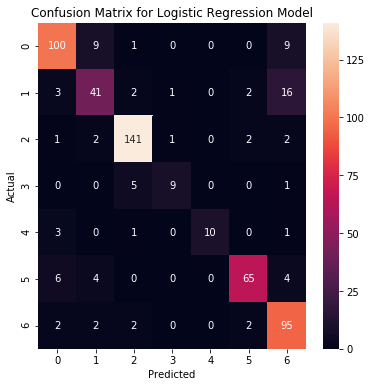

                            precision    recall  f1-score   support

Centre Setup and Expansion       0.87      0.84      0.85       119
                     Deals       0.71      0.63      0.67        65
        Executive Movement       0.93      0.95      0.94       149
                    Layoff       0.82      0.60      0.69        15
               Mass Hiring       1.00      0.67      0.80        15
  Mergers and Acquisitions       0.92      0.82      0.87        79
              Partnerships       0.74      0.92      0.82       103

                 micro avg       0.85      0.85      0.85       545
                 macro avg       0.85      0.78      0.81       545
              weighted avg       0.85      0.85      0.84       545

The test accuracy of Logistic Regression model is :84.587%


In [44]:
# Predict on the test dataset
lr_predicted=grid_lr.predict(X_test)
# call the heatmap function for Logistic Regression model
heatmapcm(y_test,lr_predicted,'Logistic Regression')
# print the classification metrics report
print(metrics.classification_report(y_test, lr_predicted,target_names=encoder.classes_))
# print the accuracy score for test dataset
print(f'The test accuracy of Logistic Regression model is :{(accuracy_score(y_test,lr_predicted)*100):.3f}%')

# *Final Model : Logistic Regression

In [28]:
# Save the Linear Regression model with TFIDF_Vectorizer for future use
joblib.dump(grid_lr, "Logistic_Regression_Python_model.sav")
joblib.dump(tfidf, "TFIDF_Vectorizer.sav")

['Logistic_Regression_Python_model.sav']

# Testing on Test data 

In [47]:
print(grid_lr.predict(tfidf.transform(["ringcentral partner pcm bring cloud communication solution enterprise"])))

[6]


In [48]:
print(grid_lr.predict(tfidf.transform(["bank baroda hire consultancy firm evaluate board performance"])))

[2]


In [49]:
print(grid_lr.predict(tfidf.transform(["pleasant hill ca u brandnew burlington store set open next week pleasant hill squarefoot store offer brandname merchandise discount price open friday may pleasant hill shopping center contra costa blvdnnwe thrilled open new burlington pleasant hill said tom kingsbury ceo chairman burlington store this new location brings job community provides great shopping experience entire family whether theyre looking brandname clothing stylish home dxecor item anything baby customer enjoy significant saving discover new merchandise arrival weeknncommunity member invited join store associate local official ribbon cutting ceremony am friday may grand opening day event continues am local resident invited among first shop new store first customer receive free burlington totennthe celebration continues saturday morning may store open am customer invited enjoy family fun day festivity am pm dj giftcard giveaway kid activitiesnnother way burlington celebrating grand opening pleasant hill store following philanthropic initiativesnnnnburlington partnership adoptaclassroomorg donate nearby school fund material teacher student need learn achieve classroomnnthroughout year new store join retailer nationwide cause marketing initiative limited to warm coat warm heart coat drive leukemia lymphoma society support adoptaclassroomorgnnsince retailer raised million dollar national cause local impact including limited to support leukemia lymphoma society adoptaclassroomorg burlington also donated million coat annual warm coat warm heart coat drive since inception nnapproximately associate hired work new store receive new merchandise week trucknnregular hour new pleasant hill store am pm monday saturday am pm sunday"])))

[0]


In [51]:
# Unseen data
print(grid_lr.predict(tfidf.transform(["I going to acquire a new company"])))

[5]


# The below part shows the above model development by balancing the imbalanced classes using SMOTE

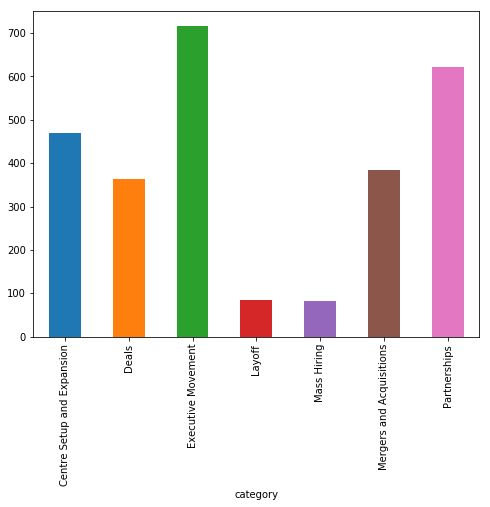

In [76]:
# Check the count of news category
fig = plt.figure(figsize=(8,6))
final_data.groupby('category').news_description.count().plot.bar(ylim=0)
plt.show()

In [23]:
# Using SMOTE sampling to balance the target classes
smote=SMOTE(ratio='auto',random_state=123)
X_smote, Y_smote = smote.fit_sample(X_train, y_train)

In [57]:
# category class count
y_train.value_counts()

2    567
6    518
0    351
5    305
1    299
3     69
4     67
Name: category, dtype: int64

In [65]:
# category class count after SMOTE sampling
pd.Series(Y_smote).value_counts()

5    567
3    567
1    567
6    567
4    567
2    567
0    567
dtype: int64

# * Random Forest Model with 4 fold Cross validation

In [66]:
# Import the random forest model
rf=RandomForestClassifier(random_state=1)
# Define the list of estimators for the Random forest to be built
est=list([100,150,200,300,500])
param_grid= dict(n_estimators=est)
print(param_grid)
# instantiate the gridsearch using random forest model
grid_rf = GridSearchCV(rf, param_grid, cv=4,scoring='accuracy', return_train_score=False)
# Fit the random forest grid
grid_rf.fit(X_smote,Y_smote)
#Print the best estimated model
print("The best cross validated estimator of Random Forest is :",grid_rf.best_estimator_)
# Print the best score of accuracy
print("The best cross validated Accuracy of Random Forest is :",grid_rf.best_score_)
#Print the given parameters & corresponding accuracy value from each 4-fold cross validation 
pd.DataFrame(grid_rf.cv_results_)[[ 'params','mean_test_score']]

{'n_estimators': [100, 150, 200, 300, 500]}
The best cross validated estimator of Random Forest is : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)
The best cross validated Accuracy of Random Forest is : 0.9183673469387755


,params,mean_test_score
0,{'n_estimators': 100},0.911565
1,{'n_estimators': 150},0.918367
2,{'n_estimators': 200},0.917611
3,{'n_estimators': 300},0.917108
4,{'n_estimators': 500},0.918115


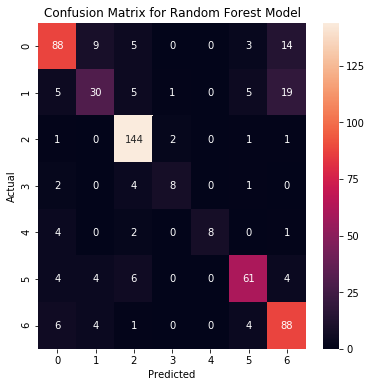

                            precision    recall  f1-score   support

Centre Setup and Expansion       0.80      0.74      0.77       119
                     Deals       0.64      0.46      0.54        65
        Executive Movement       0.86      0.97      0.91       149
                    Layoff       0.73      0.53      0.62        15
               Mass Hiring       1.00      0.53      0.70        15
  Mergers and Acquisitions       0.81      0.77      0.79        79
              Partnerships       0.69      0.85      0.77       103

                 micro avg       0.78      0.78      0.78       545
                 macro avg       0.79      0.69      0.73       545
              weighted avg       0.78      0.78      0.78       545

The test accuracy of Random Forest is :78.349%


In [67]:
# Predict on the test dataset
rf_predicted=grid_rf.predict(X_test)
# call the heatmap function for random forest
heatmapcm(y_test,rf_predicted,'Random Forest')
# print the classification metrics report
print(metrics.classification_report(y_test, rf_predicted,target_names=encoder.classes_))
# print the accuracy score for test dataset
print(f'The test accuracy of Random Forest is :{(accuracy_score(y_test, rf_predicted)*100):.3f}%')

# * Multinomial NaiveBayes model with 4 fold Cross validation

In [24]:
# Import the Multinomial NB model
nb = MultinomialNB()
# Define the list of estimators for the Multinomial NB model to be built
est=list([0.01,0.1,0.2,0.5,1,2,3,4])
param_grid= dict(alpha=est)
print(param_grid)
# instantiate the gridsearch using Multinomial NB model
grid_nb = GridSearchCV(nb, param_grid, cv=4,scoring='accuracy', return_train_score=False)
# Fit the Multinomial NB model
grid_nb.fit(X_smote,Y_smote)
#Print the best estimated model
print("The best cross validated estimator of Multinomial NB model is :",grid_nb.best_estimator_)
# Print the best score of accuracy
print("The best cross validated Accuracy of Multinomial NB model is :",grid_nb.best_score_)
#Print the given parameters & corresponding accuracy value from each 4-fold cross validation 
pd.DataFrame(grid_nb.cv_results_)[[ 'params','mean_test_score']]

{'alpha': [0.01, 0.1, 0.2, 0.5, 1, 2, 3, 4]}
The best cross validated estimator of Multinomial NB model is : MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)
The best cross validated Accuracy of Multinomial NB model is : 0.9208868732678257


,params,mean_test_score
0,{'alpha': 0.01},0.920887
1,{'alpha': 0.1},0.897959
2,{'alpha': 0.2},0.886117
3,{'alpha': 0.5},0.872512
4,{'alpha': 1},0.859410
5,{'alpha': 2},0.847065
6,{'alpha': 3},0.841270
7,{'alpha': 4},0.838750


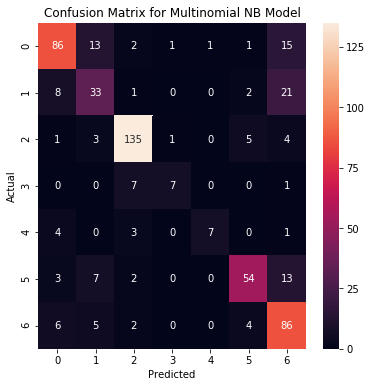

                            precision    recall  f1-score   support

Centre Setup and Expansion       0.80      0.72      0.76       119
                     Deals       0.54      0.51      0.52        65
        Executive Movement       0.89      0.91      0.90       149
                    Layoff       0.78      0.47      0.58        15
               Mass Hiring       0.88      0.47      0.61        15
  Mergers and Acquisitions       0.82      0.68      0.74        79
              Partnerships       0.61      0.83      0.70       103

                 micro avg       0.75      0.75      0.75       545
                 macro avg       0.76      0.66      0.69       545
              weighted avg       0.76      0.75      0.75       545

The test accuracy of Multiomial Naive Bayes model is :74.862%


In [25]:
# Predict on the test dataset
nb_predicted=grid_nb.predict(X_test)
# call the heatmap function for NB model
heatmapcm(y_test,nb_predicted,'Multinomial NB')
# print the classification metrics report
print(metrics.classification_report(y_test, nb_predicted,target_names=encoder.classes_))
# print the accuracy score for test dataset
print(f'The test accuracy of Multiomial Naive Bayes model is :{(accuracy_score(y_test,nb_predicted)*100):.3f}%')

# * Logistic Regression model with 4 fold Cross validation

In [26]:
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
# Import the Logistic Regression model
lr= LogisticRegression(random_state=0)
# Define the list of estimators for Logistic Regression model to be built
est=list([1,5,10,15,20,25,30])
param_grid= dict(C=est)
print(param_grid)
grid_lr = GridSearchCV(lr, param_grid, cv=4,scoring='accuracy', return_train_score=False)
# Fit the random forest grid
grid_lr.fit(X_smote,Y_smote)
#Print the best estimated model
print("The best cross validated estimator of Logistic Regression model is :",grid_lr.best_estimator_)
# Print the best score of accuracy
print("The best cross validated Accuracy of Logistic Regression model is :",grid_lr.best_score_)
#Print the given parameters & corresponding accuracy value from each 4-fold cross validation 
pd.DataFrame(grid_lr.cv_results_)[[ 'params','mean_test_score']]

{'C': [1, 5, 10, 15, 20, 25, 30]}
The best cross validated estimator of Logistic Regression model is : LogisticRegression(C=30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
The best cross validated Accuracy of Logistic Regression model is : 0.9483497102544721


,params,mean_test_score
0,{'C': 1},0.921643
1,{'C': 5},0.944067
2,{'C': 10},0.946334
3,{'C': 15},0.947090
4,{'C': 20},0.946838
5,{'C': 25},0.947090
6,{'C': 30},0.948350


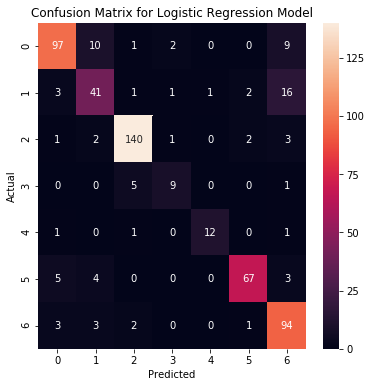

                            precision    recall  f1-score   support

Centre Setup and Expansion       0.88      0.82      0.85       119
                     Deals       0.68      0.63      0.66        65
        Executive Movement       0.93      0.94      0.94       149
                    Layoff       0.69      0.60      0.64        15
               Mass Hiring       0.92      0.80      0.86        15
  Mergers and Acquisitions       0.93      0.85      0.89        79
              Partnerships       0.74      0.91      0.82       103

                 micro avg       0.84      0.84      0.84       545
                 macro avg       0.83      0.79      0.81       545
              weighted avg       0.85      0.84      0.84       545

The test accuracy of Logistic Regression model is :84.404%


In [71]:
# Predict on the test dataset
lr_predicted=grid_lr.predict(X_test)
# call the heatmap function for Logistic Regression model
heatmapcm(y_test,lr_predicted,'Logistic Regression')
# print the classification metrics report
print(metrics.classification_report(y_test, lr_predicted,target_names=encoder.classes_))
# print the accuracy score for test dataset
print(f'The test accuracy of Logistic Regression model is :{(accuracy_score(y_test,lr_predicted)*100):.3f}%')

In [29]:
# Save the Linear Regression model with TFIDF_Vectorizer for future use
joblib.dump(grid_lr, "Logistic_Regression_SMOTE_model.sav")

['Logistic_Regression_SMOTE_model.sav']

In [73]:
print(grid_lr.predict(tfidf.transform(["ringcentral partner pcm bring cloud communication solution enterprise"])))

[6]


In [74]:
# Unseen data
print(grid_lr.predict(tfidf.transform(["I going to acquire a new company"])))

[5]
